In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import keras,os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
import numpy as np
from keras.applications import VGG16
from keras.models import Model
from keras import optimizers , layers, applications


Using TensorFlow backend.


['autism-image-data']


In [3]:
filenames = os.listdir("../input/autism-image-data/AutismDataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

train_dataframe = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

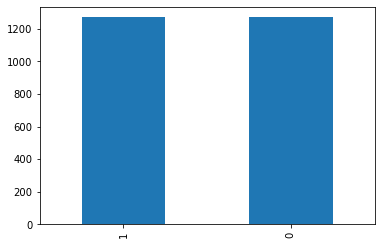

In [4]:
train_dataframe['label'].value_counts().plot.bar()


In [5]:
import os
import pandas as pd

test_filenames = os.listdir("../input/autism-image-data/AutismDataset/test")
test_categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        test_categories.append(str(1))
    else:
        test_categories.append(str(0))

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})


In [6]:
test_df.head()

,filename,category
0,Autistic.532.jpg,1
1,Non_Autistic.841.jpg,0
2,Non_Autistic.1057.jpg,0
3,Autistic.278.jpg,1
4,Autistic.193.jpg,1


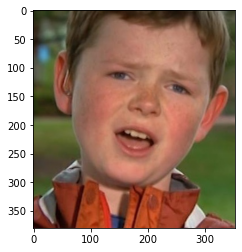

In [7]:
import random
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

sample = random.choice(file_list)
image = load_img("../input/autism-image-data/AutismDataset/train/"+sample)
plt.imshow(image)


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout
from tensorflow.keras import layers, optimizers, Model

image_size = 224
input_shape = (image_size, image_size, 3)

# Hyperparameters
num_epochs = 4
batch_size = 20

base_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

last_layer = base_model.get_layer('block5_pool')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

model.summary()


58892288/58889256 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [9]:
from sklearn.model_selection import train_test_split

# Prepare Test and Train Data
train_data, validation_data = train_test_split(train_dataframe, test_size=0.1)
train_data = train_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)

total_train = train_data.shape[0]
total_validate = validation_data.shape[0]


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training Generator with more data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    channel_shift_range=10,        # Randomly shift channels
    vertical_flip=True             # Randomly flip images vertically
)

train_generator = train_datagen.flow_from_dataframe(
    train_data, 
    "../input/autism-image-data/AutismDataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)


Found 2286 validated image filenames belonging to 2 classes.


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_data, 
    "../input/autism-image-data/AutismDataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)


Found 254 validated image filenames belonging to 2 classes.


In [12]:
# Fit Model
history = model.fit_generator(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)


Epoch 1/4
114/114 [==============================] - 59s 516ms/step - loss: 0.7039 - accuracy: 0.5499 - val_loss: 0.5479 - val_accuracy: 0.7458
Epoch 2/4
114/114 [==============================] - 52s 456ms/step - loss: 0.5711 - accuracy: 0.7070 - val_loss: 0.4813 - val_accuracy: 0.7393
Epoch 3/4
114/114 [==============================] - 52s 453ms/step - loss: 0.5282 - accuracy: 0.7246 - val_loss: 0.4093 - val_accuracy: 0.7821
Epoch 4/4
114/114 [==============================] - 51s 451ms/step - loss: 0.4853 - accuracy: 0.7568 - val_loss: 0.2807 - val_accuracy: 0.8034


In [13]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=15)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.825000  ;  loss = 0.376272 


In [14]:
# Prepare Testing
test_filenames = os.listdir("../input/autism-image-data/AutismDataset/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
num_test_samples = test_df.shape[0]


In [15]:
# Create Testing Generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/autism-image-data/AutismDataset/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)


Found 300 validated image filenames.


In [16]:
# Predict
threshold = 0.5
predictions = model.predict_generator(test_generator, steps=np.ceil(num_test_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predictions > threshold, 1, 0)


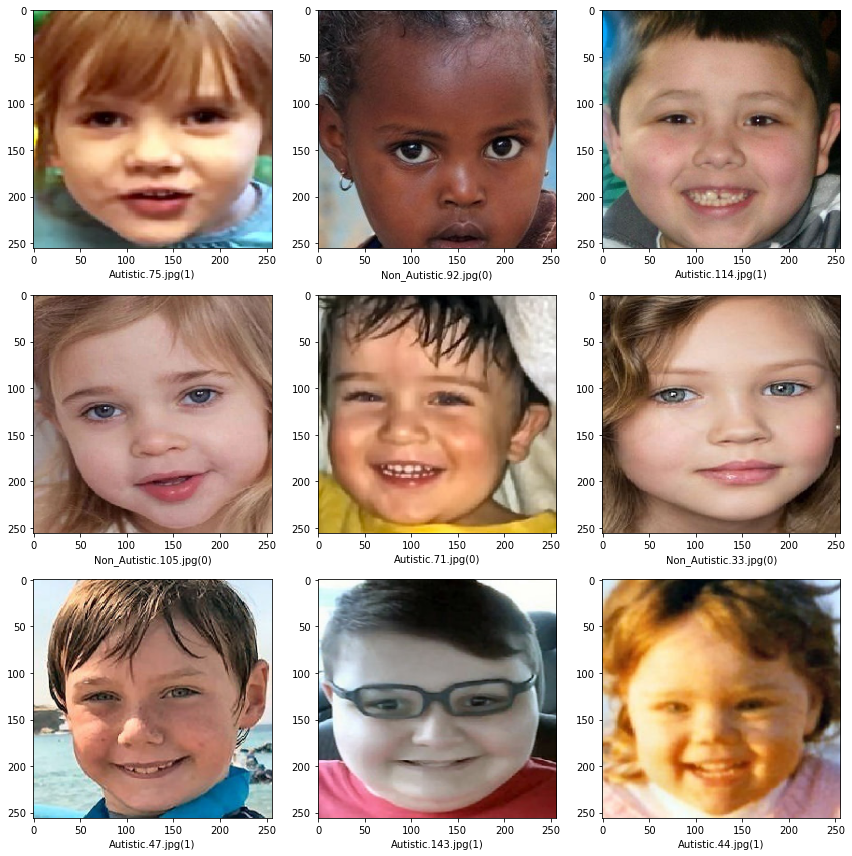

In [17]:
# See Predicted Result
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/autism-image-data/AutismDataset/test/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()
